In [ ]:
from google.colab import drive
try:
  drive.mount('/content/drive', force_remount=False)
except:
  pass

Mounted at /content/drive


In [ ]:
# Edit current drive location
%cd /content/drive/MyDrive/AI_for_Health

/content/drive/MyDrive/AI_for_Health


In [ ]:
# Edit data path
data_path = "mimic-iii-clinical-database-1.4"

# 0. Import Packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score

# 1a. Load Data

In [ ]:
# Load MIMIC datasets
diagnoses = pd.read_csv(os.path.join(data_path,'DIAGNOSES_ICD.csv.gz'), compression="gzip",
                        usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE","SEQ_NUM"])
patients = pd.read_csv(os.path.join(data_path,'PATIENTS.csv.gz'), compression="gzip",
                       usecols=["SUBJECT_ID", "GENDER", "DOB"])
admissions = pd.read_csv(os.path.join(data_path,'ADMISSIONS.csv.gz'), compression="gzip",
                         usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME",
                                  "DEATHTIME", "ADMISSION_TYPE", "ETHNICITY", "INSURANCE"])
icustays = pd.read_csv(os.path.join(data_path,'ICUSTAYS.csv.gz'), compression="gzip",
                       usecols=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID","FIRST_CAREUNIT","INTIME","OUTTIME","LOS"])

# Load aggregated chartevents data (aggregated in SQL)
chartevents = pd.read_csv("finalproject_chartevents_agg.csv")

# 1b. Feature Engineering

### 1. Target variable definition

In [ ]:
# Flag for ICD9 codes indicating emergency heart failure
surgery_patients = diagnoses[["SUBJECT_ID", "HADM_ID", "ICD9_CODE"]]
surgery_patients['Target'] = surgery_patients['ICD9_CODE'].isin([
            '4280',   # Congestive heart failure, unspecified
            '42821',  # Acute systolic heart failure
            '42820'   # Systolic heart failure, unspecified
])
surgery_patients['Target'] = surgery_patients['Target'].astype(int)

# Aggregate to an admission level
surgery_patients = surgery_patients.groupby(['SUBJECT_ID','HADM_ID'])['Target'].max().reset_index()

# Identify patients requiring emergency care if admission type is Emergency
surgery_patients = pd.merge(surgery_patients, admissions[['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE']], on=['SUBJECT_ID', 'HADM_ID'])
surgery_patients['Target'] = np.where(surgery_patients['ADMISSION_TYPE'] == 'EMERGENCY', surgery_patients['Target'], 0)
surgery_patients = surgery_patients.drop(columns=['ADMISSION_TYPE'])

In [ ]:
print(diagnoses['HADM_ID'].nunique())
print(surgery_patients['HADM_ID'].nunique())
surgery_patients['Target'].value_counts()

58976
58976


,count
Target,
0,47511
1,11465


### 2. Demographic features

In [ ]:
# Merge admissions and patients data
demog_data = pd.merge(admissions, patients, on="SUBJECT_ID")

In [ ]:
demog_data["INSURANCE"].value_counts()

,count
INSURANCE,
Medicare,28215
Private,22582
Medicaid,5785
Government,1783
Self Pay,611


In [ ]:
# Calculate age function
def calculate_age(dob, admit):
  try:
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    admit_date = datetime.strptime(admit, "%Y-%m-%d %H:%M:%S")
    age = (admit_date - dob_date).days // 365
    return age
  except ValueError as e:
    print(f"Error processing dates: {e}")
    return None

# Apply calculate_age function to create "age" column
demog_data["DOB"] = demog_data["DOB"].astype(str)
demog_data["ADMITTIME"] = demog_data["ADMITTIME"].astype(str)
demog_data["age"] = demog_data.apply(lambda row: calculate_age(row["DOB"], row["ADMITTIME"]), axis=1)

# Filter for admissions that have age within range 0-100 years
demog_data = demog_data[demog_data["age"] <= 100]

In [ ]:
# Compress the number of ethnicity categories
demog_data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
demog_data['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
demog_data['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
demog_data['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
demog_data['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
demog_data['ETHNICITY'].loc[~demog_data['ETHNICITY'].isin(demog_data['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
demog_data['ETHNICITY'].value_counts()

<ipython-input-11-59af5a4a0037>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  demog_data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-11-59af5a4a0037>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demog_data['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-11-59a

,count
ETHNICITY,
WHITE,39135
OTHER/UNKNOWN,7515
BLACK/AFRICAN AMERICAN,5646
HISPANIC/LATINO,2112
ASIAN,1952


### 3. Hospital features

In [ ]:
# Aggregate length of stay to an admission level
los_data = icustays.groupby(["SUBJECT_ID", "HADM_ID"]).agg({"LOS": "sum", "INTIME": "min"}).reset_index()

In [ ]:
# Calculate the number of previous ICU admissions a patients has had (at the time of their current admission)
first_ICU_admit = los_data.groupby(["SUBJECT_ID"]).agg({"INTIME": "min"}).reset_index()
first_ICU_admit.rename(columns={"INTIME": "first_ICU_admit"}, inplace=True)
prev_ICU_admit = pd.merge(los_data, first_ICU_admit, on="SUBJECT_ID")
prev_ICU_admit["prev_ICU_admit"] = (prev_ICU_admit["INTIME"] > prev_ICU_admit["first_ICU_admit"]).astype(int)
prev_ICU_admit["prev_ICU_admit"].value_counts()

,count
prev_ICU_admit,
0,46476
1,11310


### 4. Clinical features

In [ ]:
clinic_data = chartevents.copy()

clinic_data.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID', 'itemid': 'ITEMID'}, inplace=True)
clinic_data.dropna(inplace=True)

# List of relevant lab test ITEMIDs
relevant_vitals = {211: "Heart_Rate_cv",
                   220045: "Heart_Rate_meta",
                   220179: "BP_meta",
                   455: "BP_cv",
                   422: "Manual_BP_cv",
                   224167: "Manual_BP_left_meta",
                   227243: "Manual_BP_right_meta",
                   220277: "SpO2_meta",
                   646: "SpO2_cv",
                   678: "Temp_F",
                   679: "Temp_F_calc",
                   223761: "Temp_F_meta"}

# Filter for relevant lab tests
clinic_data = clinic_data[clinic_data["ITEMID"].isin(relevant_vitals.keys())]

# Replace itemid with human-readable names
clinic_data["vital_name"] = clinic_data["ITEMID"].map(relevant_vitals)

# Pivot the table: Create separate columns for each lab_name's mean and std
clinic_pivot = clinic_data.pivot_table(index=["SUBJECT_ID", "HADM_ID"],
                                    columns="vital_name",
                                    values=['mean_value', 'std_value'])

# Flatten multi-index column names
clinic_pivot.columns = [f"{metric}_{lab}" for metric, lab in clinic_pivot.columns]
clinic_pivot.columns = [x.removeprefix('_value') for x in clinic_pivot.columns]

# Reset index to ensure subject_id and hadm_id remain as columns
clinic_pivot = clinic_pivot.reset_index()

In [ ]:
# Fill in missing values in heart rate by combining cv and meta values
clinic_pivot['mean_value_heart_rate_new'] = clinic_pivot['mean_value_Heart_Rate_cv']
clinic_pivot['mean_value_heart_rate_new'].fillna(clinic_pivot['mean_value_Heart_Rate_meta'], inplace=True)
clinic_pivot['std_value_heart_rate_new'] = clinic_pivot['std_value_Heart_Rate_cv']
clinic_pivot['std_value_heart_rate_new'].fillna(clinic_pivot['std_value_Heart_Rate_meta'], inplace=True)

# Fill in missing values in temperature by combining cv and meta values
clinic_pivot['mean_value_temp_F_new'] = clinic_pivot['mean_value_Temp_F']
clinic_pivot['mean_value_temp_F_new'].fillna(clinic_pivot['mean_value_Temp_F_meta'], inplace=True)
clinic_pivot['mean_value_temp_F_new'].fillna(clinic_pivot['mean_value_Temp_F_calc'], inplace=True)
clinic_pivot['std_value_temp_F_new'] = clinic_pivot['std_value_Temp_F']
clinic_pivot['std_value_temp_F_new'].fillna(clinic_pivot['std_value_Temp_F_meta'], inplace=True)
clinic_pivot['std_value_temp_F_new'].fillna(clinic_pivot['std_value_Temp_F_calc'], inplace=True)

# Fill in missing values in blood pressure by combining cv and meta values
clinic_pivot['mean_value_BP_new'] = clinic_pivot['mean_value_BP_cv']
clinic_pivot['mean_value_BP_new'].fillna(clinic_pivot['mean_value_BP_meta'], inplace=True)
clinic_pivot['std_value_BP_new'] = clinic_pivot['std_value_BP_cv']
clinic_pivot['std_value_BP_new'].fillna(clinic_pivot['std_value_BP_meta'], inplace=True)

# Fill in missing values in SpO2 by combining cv and meta values
clinic_pivot['mean_value_SpO2_new'] = clinic_pivot['mean_value_SpO2_cv']
clinic_pivot['mean_value_SpO2_new'].fillna(clinic_pivot['mean_value_SpO2_meta'], inplace=True)
clinic_pivot['std_value_SpO2_new'] = clinic_pivot['std_value_SpO2_cv']
clinic_pivot['std_value_SpO2_new'].fillna(clinic_pivot['std_value_SpO2_meta'], inplace=True)

<ipython-input-16-c6fd12a4f2d7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clinic_pivot['mean_value_heart_rate_new'].fillna(clinic_pivot['mean_value_Heart_Rate_meta'], inplace=True)
<ipython-input-16-c6fd12a4f2d7>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [ ]:
clinic_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54880 entries, 0 to 54879
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SUBJECT_ID                       54880 non-null  int64  
 1   HADM_ID                          54880 non-null  int64  
 2   mean_value_BP_cv                 26046 non-null  float64
 3   mean_value_BP_meta               21567 non-null  float64
 4   mean_value_Heart_Rate_cv         33068 non-null  float64
 5   mean_value_Heart_Rate_meta       21915 non-null  float64
 6   mean_value_Manual_BP_left_meta   234 non-null    float64
 7   mean_value_Manual_BP_right_meta  195 non-null    float64
 8   mean_value_SpO2_cv               27179 non-null  float64
 9   mean_value_SpO2_meta             21885 non-null  float64
 10  mean_value_Temp_F                26061 non-null  float64
 11  mean_value_Temp_F_calc           5776 non-null   float64
 12  mean_value_Temp_F_

In [ ]:
# Select required features (discarding cv specific and meta specific variables)
clinic_pivot = clinic_pivot[['SUBJECT_ID', 'HADM_ID',
                             'mean_value_heart_rate_new', 'std_value_heart_rate_new',
                             'mean_value_temp_F_new', 'std_value_temp_F_new',
                             'mean_value_BP_new', 'std_value_BP_new',
                             'mean_value_SpO2_new', 'std_value_SpO2_new']]

### 5. Join all datasets

In [ ]:
# Merge all created features into one df
df = pd.merge(surgery_patients, demog_data, on=["SUBJECT_ID", "HADM_ID"])
df = pd.merge(df, prev_ICU_admit, on=["SUBJECT_ID", "HADM_ID"])
df = pd.merge(df, clinic_pivot, on=["SUBJECT_ID", "HADM_ID"])

# 1c. Data Processing

### 1. Drop rows that have NA values

In [ ]:
# Drop unrequired columns
df.drop(columns=['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'DOB', 'INTIME', 'first_ICU_admit'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52289 entries, 0 to 52288
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SUBJECT_ID                 52289 non-null  int64  
 1   HADM_ID                    52289 non-null  int64  
 2   Target                     52289 non-null  int64  
 3   ADMISSION_TYPE             52289 non-null  object 
 4   INSURANCE                  52289 non-null  object 
 5   ETHNICITY                  52289 non-null  object 
 6   GENDER                     52289 non-null  object 
 7   age                        52289 non-null  int64  
 8   LOS                        52289 non-null  float64
 9   prev_ICU_admit             52289 non-null  int64  
 10  mean_value_heart_rate_new  52288 non-null  float64
 11  std_value_heart_rate_new   52288 non-null  float64
 12  mean_value_temp_F_new      45690 non-null  float64
 13  std_value_temp_F_new       45690 non-null  flo

In [ ]:
# Remove any rows that have NA values
df_rem_NA = df.copy()
df_rem_NA.dropna(inplace=True)

In [ ]:
df_rem_NA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44306 entries, 1 to 52288
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SUBJECT_ID                 44306 non-null  int64  
 1   HADM_ID                    44306 non-null  int64  
 2   Target                     44306 non-null  int64  
 3   ADMISSION_TYPE             44306 non-null  object 
 4   INSURANCE                  44306 non-null  object 
 5   ETHNICITY                  44306 non-null  object 
 6   GENDER                     44306 non-null  object 
 7   age                        44306 non-null  int64  
 8   LOS                        44306 non-null  float64
 9   prev_ICU_admit             44306 non-null  int64  
 10  mean_value_heart_rate_new  44306 non-null  float64
 11  std_value_heart_rate_new   44306 non-null  float64
 12  mean_value_temp_F_new      44306 non-null  float64
 13  std_value_temp_F_new       44306 non-null  float64


In [ ]:
df_rem_NA['Target'].value_counts()

,count
Target,
0,34482
1,9824


### 2. One-hot encoding for categorical features

In [ ]:
df_dummyvar = pd.get_dummies(df_rem_NA, columns=['ADMISSION_TYPE', 'INSURANCE', 'ETHNICITY', 'GENDER'])

### 3. Check and correct imbalances in the data

In [ ]:
df_dummyvar['Target'].value_counts()

,count
Target,
0,34482
1,9824


In [ ]:
# Undersample Majority Class
df_majority = df_dummyvar[df_dummyvar["Target"] == 0].sample(n=9824, random_state=42)  # Keep 9,824 non-target cases
df_minority = df_dummyvar[df_dummyvar["Target"] == 1]  # Keep all 9,824 target cases

# Merge both subsets
df_balanced = pd.concat([df_majority, df_minority])

### 4. Split into train and test

In [ ]:
# Split data
X = df_balanced.drop(columns=['SUBJECT_ID', 'HADM_ID', 'Target'])
y = df_balanced['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (15718, 26)
Test shape: (3930, 26)


In [ ]:
y_train.value_counts()

,count
Target,
1,7859
0,7859


# 2. Bias Analysis - XGBoost model (with sensitive demographic features)

### 1. XGBoost model construction

In [ ]:
# Model training and evaluation functions
def train_and_evaluate_model(model, model_name, x_tr, x_te, y_tr, y_te, sample_weight=None):
  print(f"\nTraining {model_name}...\n")

  start_time = time.time()
  if sample_weight is not None:
    model.fit(x_tr, y_tr, sample_weight=sample_weight)
  else:
    model.fit(x_tr, y_tr)
  end_time = time.time()
  print(f"Training Time: {end_time - start_time:.2f} seconds")
  train_time = end_time - start_time
  start_time = time.time()
  y_pr = model.predict(x_te)
  end_time = time.time()
  print(f"Inference Time: {end_time - start_time:.2f} seconds")
  infer_time = end_time - start_time

  print(f"\nResults for {model_name}:")
  print(classification_report(y_te, y_pr))
  return y_pr, model, train_time, infer_time

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1,2,3], yticklabels=[1,2,3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [ ]:
# Define model
np.random.seed(42)
xgboost = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, objective="multi:softmax", num_class=2)

# Train & Evaluate
xgb_preds, xgb_model, xgb_trtime, xgb_inftime = train_and_evaluate_model(xgboost, "XGBoost", X_train, X_test, y_train, y_test)


Training XGBoost...

Training Time: 1.86 seconds
Inference Time: 0.02 seconds

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1965
           1       0.71      0.79      0.75      1965

    accuracy                           0.73      3930
   macro avg       0.73      0.73      0.73      3930
weighted avg       0.73      0.73      0.73      3930



In [ ]:
feature_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
feature_importance

,Feature,Importance
12,ADMISSION_TYPE_EMERGENCY,0.581856
16,INSURANCE_Medicare,0.076766
2,prev_ICU_admit,0.066251
0,age,0.046117
20,ETHNICITY_BLACK/AFRICAN AMERICAN,0.020321
10,std_value_SpO2_new,0.016297
1,LOS,0.015603
7,mean_value_BP_new,0.015261
4,std_value_heart_rate_new,0.012340
23,ETHNICITY_WHITE,0.012249


### 2. Model performance across groups

In [ ]:
# Function to get model performance on each demographic group
def performance_per_group(xtest, ytest, model, dummy_vars, rem_prefix):
  bias_results = {}

  for var in dummy_vars:
    x_subset = xtest[xtest[var] == 1]
    y_subset = ytest[xtest[var] == 1]

    if len(y_subset) < 30:
      continue

    y_pred = model.predict(x_subset)
    y_pred_prob = model.predict_proba(x_subset)[:, 1]

    auc = roc_auc_score(y_subset, y_pred_prob)
    report = classification_report(y_subset, y_pred, output_dict=True)

    bias_results[var.removeprefix(rem_prefix)] = {
        "AUC": auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
    }
  bias_df = pd.DataFrame(bias_results).T
  return bias_df

In [ ]:
# Performance across socioeconomic/insurance groups
bias_insurance_df = performance_per_group(X_test, y_test, xgboost, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_')
print(bias_insurance_df)

                 AUC  Precision    Recall  F1-score
Government  0.830893   0.727273  0.551724  0.627451
Medicaid    0.797057   0.660377  0.608696  0.633484
Medicare    0.741734   0.721035  0.875683  0.790870
Private     0.820420   0.629630  0.529745  0.575385
Self Pay    0.891667   0.666667  0.500000  0.571429


In [ ]:
# Performance across ethnicity
bias_ethnic_df = performance_per_group(X_test, y_test, xgboost, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_')
print(bias_ethnic_df)

                             AUC  Precision    Recall  F1-score
ASIAN                   0.885370   0.657143  0.884615  0.754098
BLACK/AFRICAN AMERICAN  0.779144   0.767677  0.832117  0.798599
HISPANIC/LATINO         0.813620   0.682540  0.693548  0.688000
OTHER/UNKNOWN           0.827238   0.673554  0.747706  0.708696
WHITE                   0.803861   0.701083  0.794224  0.744753


### 3. Disparate Impact Analysis

In [ ]:
# Function to reconstruct a single variable with categories from multiple one-hot encoded variables
def reconstruct_categorical_vars(df, categs_dict, new_var_name):
  df[new_var_name] = ""
  for categ, dummyvar in categs_dict.items():
    df.loc[df[dummyvar] == 1, new_var_name] = categ
  return df


# Calculate disparate impact
def disparate_impact_calc(xtest, ytest, model, categ, categs_dict):
  df_test = xtest.copy()
  # Get model predictions
  df_test["ypred"] = model.predict(df_test)

  # Reconstruct categorical column from dummy variables (for grouping purposes in next step)
  df_test = reconstruct_categorical_vars(df_test, categs_dict, categ)

  # Calculate positive prediction rate for each insurance group
  positive_rates = df_test.groupby(categ)["ypred"].mean()
  reference_group = positive_rates.max()  # Usually the highest-performing group
  disparate_impact = positive_rates / reference_group
  print(disparate_impact)

In [ ]:
# Disparate impact analysis across socioeconomic/insurance groups
disparate_impact_calc(X_test, y_test, xgboost, 'Insurance', {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'})

Insurance
Government    0.285681
Medicaid      0.452901
Medicare      1.000000
Private       0.348435
Self Pay      0.116870
Name: ypred, dtype: float64


In [ ]:
# Disparate impact analysis across ethnicity
disparate_impact_calc(X_test, y_test, xgboost, 'Ethnicity', {'ASIAN':'ETHNICITY_ASIAN','BLACK/AFRICAN AMERICAN':'ETHNICITY_BLACK/AFRICAN AMERICAN',
                                                             'HISPANIC/LATINO':'ETHNICITY_HISPANIC/LATINO','OTHER/UNKNOWN':'ETHNICITY_OTHER/UNKNOWN','WHITE':'ETHNICITY_WHITE'})

Ethnicity
ASIAN                     0.684114
BLACK/AFRICAN AMERICAN    1.000000
HISPANIC/LATINO           0.663064
OTHER/UNKNOWN             0.721232
WHITE                     0.856209
Name: ypred, dtype: float64


### 4. Equalized Odds Analysis

In [ ]:
# Calculate TPR and FPR score for equalized odds test
def equalized_odds_difference(xtest, ytest, model, dummy_vars, rem_prefix):

  # Compute confusion matrices for each group
  for var in dummy_vars:
    x_subset = xtest[xtest[var] == 1]
    y_subset = ytest[xtest[var] == 1]
    y_pred = model.predict(x_subset)

    cm = confusion_matrix(y_subset, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn)  # False positive rate
    tpr = tp / (tp + fn)  # True positive rate

    print(f"{var.removeprefix(rem_prefix)}: FPR={fpr:.3f}, TPR={tpr:.3f}")

In [ ]:
# TPR and FPR analysis across socioeconomic/insurance groups
equalized_odds_difference(X_test, y_test, xgboost, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_')

Government: FPR=0.082, TPR=0.552
Medicaid: FPR=0.185, TPR=0.609
Medicare: FPR=0.557, TPR=0.876
Private: FPR=0.142, TPR=0.530
Self Pay: FPR=0.033, TPR=0.500


In [ ]:
# TPR and FPR analysis across ethnicity
equalized_odds_difference(X_test, y_test, xgboost, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_')

ASIAN: FPR=0.235, TPR=0.885
BLACK/AFRICAN AMERICAN: FPR=0.399, TPR=0.832
HISPANIC/LATINO: FPR=0.247, TPR=0.694
OTHER/UNKNOWN: FPR=0.275, TPR=0.748
WHITE: FPR=0.342, TPR=0.794


# 3. Bias Analysis - XGBoost model without sensitive demographic features

### 1. XGBoost model construction

In [ ]:
demog_columns = ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay',
                 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_OTHER/UNKNOWN', 'ETHNICITY_WHITE']
X_train_remdemog = X_train.drop(columns=demog_columns)
X_test_remdemog = X_test.drop(columns=demog_columns)

In [ ]:
# Define model
np.random.seed(42)
xgboost_remdemog = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, objective="multi:softmax", num_class=3)

# Train & Evaluate
xgb_preds_remdemog, xgb_model_remdemog, xgb_trtime_remdemog, xgb_inftime_remdemog = train_and_evaluate_model(xgboost_remdemog, "XGBoost", X_train_remdemog, X_test_remdemog, y_train, y_test)


Training XGBoost...

Training Time: 6.57 seconds
Inference Time: 0.15 seconds

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71      1965
           1       0.71      0.79      0.75      1965

    accuracy                           0.73      3930
   macro avg       0.74      0.73      0.73      3930
weighted avg       0.74      0.73      0.73      3930



### 2. Model performance across groups

In [ ]:
# Function to get model performance on each demographic group
def performance_per_group_remdemog(xtest, ytest, model, dummy_vars, rem_prefix, demog_columns):
  bias_results = {}

  for var in dummy_vars:
    x_subset = xtest[xtest[var] == 1]
    x_subset = x_subset.drop(columns=demog_columns)
    y_subset = ytest[xtest[var] == 1]

    if len(y_subset) < 30:
      continue

    y_pred = model.predict(x_subset)
    y_pred_prob = model.predict_proba(x_subset)[:, 1]

    auc = roc_auc_score(y_subset, y_pred_prob)
    report = classification_report(y_subset, y_pred, output_dict=True)

    bias_results[var.removeprefix(rem_prefix)] = {
        "AUC": auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
    }
  bias_df = pd.DataFrame(bias_results).T
  return bias_df

In [ ]:
# Performance across socioeconomic/insurance groups
bias_insurance_df_remdemog = performance_per_group_remdemog(X_test, y_test, xgb_model_remdemog, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_', demog_columns)
print(bias_insurance_df_remdemog)

                 AUC  Precision    Recall  F1-score
Government  0.840812   0.772727  0.586207  0.666667
Medicaid    0.782832   0.672727  0.643478  0.657778
Medicare    0.737877   0.724771  0.863388  0.788030
Private     0.819412   0.621951  0.577904  0.599119
Self Pay    0.875000   0.500000  0.500000  0.500000


In [ ]:
# Performance across ethnicity
bias_ethnic_df_remdemog = performance_per_group_remdemog(X_test, y_test, xgb_model_remdemog, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_', demog_columns)
print(bias_ethnic_df_remdemog)

                             AUC  Precision    Recall  F1-score
ASIAN                   0.893665   0.666667  1.000000  0.800000
BLACK/AFRICAN AMERICAN  0.781655   0.795367  0.751825  0.772983
HISPANIC/LATINO         0.829550   0.711864  0.677419  0.694215
OTHER/UNKNOWN           0.817009   0.665254  0.720183  0.691630
WHITE                   0.803689   0.699690  0.815884  0.753333


### 3. Disparate Impact Analysis

In [ ]:
# Calculate disparate impact
def disparate_impact_calc_remdemog(xtest, ytest, model, categ, categs_dict, demog_columns):
  df_test = xtest.copy()
  # Get model predictions
  df_test2 = df_test.drop(columns=demog_columns)
  df_test["ypred"] = model.predict(df_test2)

  # Reconstruct categorical column from dummy variables (for grouping purposes in next step)
  df_test = reconstruct_categorical_vars(df_test, categs_dict, categ)

  # Calculate positive prediction rate for each insurance group
  positive_rates = df_test.groupby(categ)["ypred"].mean()
  reference_group = positive_rates.max()  # Usually the highest-performing group
  disparate_impact = positive_rates / reference_group
  print(disparate_impact)

In [ ]:
# Disparate impact analysis across socioeconomic/insurance groups
disparate_impact_calc_remdemog(X_test, y_test, xgb_model_remdemog, 'Insurance', {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'}, demog_columns)

Insurance
Government    0.291251
Medicaid      0.479154
Medicare      1.000000
Private       0.392305
Self Pay      0.158864
Name: ypred, dtype: float64


In [ ]:
# Disparate impact analysis across ethnicity
disparate_impact_calc_remdemog(X_test, y_test, xgb_model_remdemog, 'Ethnicity', {'ASIAN':'ETHNICITY_ASIAN','BLACK/AFRICAN AMERICAN':'ETHNICITY_BLACK/AFRICAN AMERICAN',
                                                             'HISPANIC/LATINO':'ETHNICITY_HISPANIC/LATINO','OTHER/UNKNOWN':'ETHNICITY_OTHER/UNKNOWN','WHITE':'ETHNICITY_WHITE'}, demog_columns)

Ethnicity
ASIAN                     0.864959
BLACK/AFRICAN AMERICAN    0.989496
HISPANIC/LATINO           0.704592
OTHER/UNKNOWN             0.798073
WHITE                     1.000000
Name: ypred, dtype: float64


### 4. Equalized Odds Analysis

In [ ]:
# Calculate TPR and FPR score for equalized odds test
def equalized_odds_difference_remdemog(xtest, ytest, model, dummy_vars, rem_prefix, demog_columns):

  # Compute confusion matrices for each group
  for var in dummy_vars:
    x_subset = xtest[xtest[var] == 1]
    x_subset = x_subset.drop(columns=demog_columns)
    y_subset = ytest[xtest[var] == 1]
    y_pred = model.predict(x_subset)

    cm = confusion_matrix(y_subset, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn)  # False positive rate
    tpr = tp / (tp + fn)  # True positive rate

    print(f"{var.removeprefix(rem_prefix)}: FPR={fpr:.3f}, TPR={tpr:.3f}")

In [ ]:
# TPR and FPR analysis across socioeconomic/insurance groups
equalized_odds_difference_remdemog(X_test, y_test, xgb_model_remdemog, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_', demog_columns)

Government: FPR=0.068, TPR=0.586
Medicaid: FPR=0.185, TPR=0.643
Medicare: FPR=0.539, TPR=0.863
Private: FPR=0.160, TPR=0.578
Self Pay: FPR=0.067, TPR=0.500


In [ ]:
# TPR and FPR analysis across ethnicity
equalized_odds_difference_remdemog(X_test, y_test, xgb_model_remdemog, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_', demog_columns)

ASIAN: FPR=0.255, TPR=1.000
BLACK/AFRICAN AMERICAN: FPR=0.306, TPR=0.752
HISPANIC/LATINO: FPR=0.210, TPR=0.677
OTHER/UNKNOWN: FPR=0.275, TPR=0.720
WHITE: FPR=0.353, TPR=0.816


# 4. Bias Analysis - Counterfactual Fairness Test plan

In [ ]:
# Generate counterfactual data samples by replacing the sensitive demographic value with every unique value in that variable
def generate_counterfactuals(X_features, demographics, col_name):
    counterfactuals = []
    unique_vals = demographics[col_name].unique()

    for idx in range(len(X_features)):
        original_features = X_features.iloc[idx]
        for val in unique_vals:
            if val != demographics.iloc[idx][col_name]:
                new_demo = demographics.iloc[idx].copy()
                new_demo[col_name] = val
                new_row = pd.concat([original_features, new_demo])
                counterfactuals.append((idx, new_row))

    # Convert to DataFrame
    cf_df = pd.DataFrame([row[1] for row in counterfactuals])  # Extract feature vectors
    cf_df.index = [row[0] for row in counterfactuals]  # Restore original indices

    # One-hot encoding for categorical variables
    cf_df2 = pd.get_dummies(cf_df, columns=['INSURANCE','ETHNICITY'])

    return cf_df2


# Calculate counterfactual fairness score
def evaluate_counterfactual_fairness(model, cf_test, xtest, ytest, tolerance, demog_cols):
  xtest['y_true'] = ytest

  # Compute prediction probabilities
  cf_test['y_prob'] = model.predict_proba(cf_test[model.feature_names_in_])[:, 1]
  xtest['y_prob'] = model.predict_proba(xtest[xgb_model.feature_names_in_])[:, 1]

  # Identify number of inconsistent predictions that have occured because of sensitive feature value swap
  merge_cf_x = pd.merge(cf_test, xtest[['y_prob'] + demog_cols], left_index=True, right_index=True, suffixes=('', '_orig'))
  merge_cf_x['abs_diff'] = abs(merge_cf_x['y_prob'] - merge_cf_x['y_prob_orig'])
  merge_cf_x['inconsistent_preds'] = (merge_cf_x['abs_diff'] > tolerance).astype(int)

  # Calculate counterfactual fairness score
  total_cf = len(merge_cf_x)
  fairness_score = 1 - (merge_cf_x['inconsistent_preds'].sum() / total_cf)
  print(f"Counterfactual Fairness Score: {fairness_score:.3f}")

  return fairness_score, merge_cf_x, tolerance

In [ ]:
# Prepare demographic only data
demogonly_train = X_train[demog_columns]
demogonly_test = X_test[demog_columns]

# Reconstruct Insurance and Ethnicity in train data
demogonly_train = reconstruct_categorical_vars(demogonly_train, {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'}, 'INSURANCE')
demogonly_train = reconstruct_categorical_vars(demogonly_train, {'ASIAN':'ETHNICITY_ASIAN','BLACK/AFRICAN AMERICAN':'ETHNICITY_BLACK/AFRICAN AMERICAN','HISPANIC/LATINO':'ETHNICITY_HISPANIC/LATINO','OTHER/UNKNOWN':'ETHNICITY_OTHER/UNKNOWN','WHITE':'ETHNICITY_WHITE'}, 'ETHNICITY')
demogonly_train.drop(columns=demog_columns, inplace=True)
demogonly_test = reconstruct_categorical_vars(demogonly_test, {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'}, 'INSURANCE')
demogonly_test = reconstruct_categorical_vars(demogonly_test, {'ASIAN':'ETHNICITY_ASIAN','BLACK/AFRICAN AMERICAN':'ETHNICITY_BLACK/AFRICAN AMERICAN','HISPANIC/LATINO':'ETHNICITY_HISPANIC/LATINO','OTHER/UNKNOWN':'ETHNICITY_OTHER/UNKNOWN','WHITE':'ETHNICITY_WHITE'}, 'ETHNICITY')
demogonly_test.drop(columns=demog_columns, inplace=True)

# Generate counterfactual data for Insurance
cf_insurance_test = generate_counterfactuals(X_test_remdemog, demogonly_test, 'INSURANCE')

# Generate counterfactual data for Ethnicity
cf_ethnicity_test = generate_counterfactuals(X_test_remdemog, demogonly_test, 'ETHNICITY')

In [ ]:
# Counterfactual fairness score for Insurance, threshold = 5%
cf_fairness_insurance, cf_pred_insurance, cf_thresh_insurance = evaluate_counterfactual_fairness(xgb_model, cf_insurance_test, X_test, y_test, 0.05,
                                                                         ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'])

Counterfactual Fairness Score: 0.094


In [ ]:
# Counterfactual fairness score for Insurance, threshold = 20%
cf_fairness_insurance, cf_pred_insurance, cf_thresh_insurance = evaluate_counterfactual_fairness(xgb_model, cf_insurance_test, X_test, y_test, 0.2,
                                                                         ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'])

Counterfactual Fairness Score: 0.345


In [ ]:
# Counterfactual fairness score for Ethnicity, threshold = 5%
cf_fairness_ethnicity, cf_pred_ethnicity, cf_thresh_ethnicity = evaluate_counterfactual_fairness(xgb_model, cf_ethnicity_test, X_test, y_test, 0.05,
                                                                         ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'])

Counterfactual Fairness Score: 0.115


In [ ]:
# Counterfactual fairness score for Ethnicity, threshold = 20%
cf_fairness_ethnicity, cf_pred_ethnicity, cf_thresh_ethnicity = evaluate_counterfactual_fairness(xgb_model, cf_ethnicity_test, X_test, y_test, 0.2,
                                                                         ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'])

Counterfactual Fairness Score: 0.389


# 5. Bias Mitigation Techniques

### 1. Pre-processing technique: Reweighting method

In [ ]:
# Calculate sample weights
def calculate_sample_weights(xtrain, categs_dict, new_var_name):
  # Reconstruct group variable
  xtrain = reconstruct_categorical_vars(xtrain, categs_dict, new_var_name)
  group_column = xtrain[new_var_name]
  xtrain.drop(columns=[new_var_name], inplace=True)

  # Calculate group proportions
  group_counts = group_column.value_counts(normalize=True)
  weights = 1 / group_counts  # Inverse proportion weighting

  # Assign weights based on each sample’s group
  sample_weights = group_column.map(weights)
  return sample_weights

In [ ]:
# Calculate sample weights for demographic feature: Insurance
sample_weights_insurance = calculate_sample_weights(X, {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'}, 'Insurance')

# Split data
X_train_swi, X_test_swi, y_train_swi, y_test_swi, w_train_swi, w_test_swi = train_test_split(X, y, sample_weights_insurance, test_size=0.2, random_state=42)

In [ ]:
# Define model
np.random.seed(42)
xgboost_swi = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, objective="multi:softmax", num_class=3)

# Train & Evaluate
xgb_preds_swi, xgb_model_swi, xgb_trtime_swi, xgb_inftime_swi = train_and_evaluate_model(xgboost_swi, "XGBoost - Weighted for Insurance", X_train_swi, X_test_swi, y_train_swi, y_test_swi, w_train_swi)


Training XGBoost - Weighted for Insurance...

Training Time: 5.45 seconds
Inference Time: 0.09 seconds

Results for XGBoost - Weighted for Insurance:
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1982
           1       0.70      0.79      0.74      1948

    accuracy                           0.73      3930
   macro avg       0.73      0.73      0.72      3930
weighted avg       0.73      0.73      0.72      3930



In [ ]:
# Performance across socioeconomic/insurance groups
bias_insurance_df_swi = performance_per_group(X_test_swi, y_test_swi, xgboost_swi, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_')
print(bias_insurance_df)

                 AUC  Precision    Recall  F1-score
Government  0.830893   0.727273  0.551724  0.627451
Medicaid    0.797057   0.660377  0.608696  0.633484
Medicare    0.741734   0.721035  0.875683  0.790870
Private     0.820420   0.629630  0.529745  0.575385
Self Pay    0.891667   0.666667  0.500000  0.571429


In [ ]:
# Disparate impact analysis across socioeconomic/insurance groups
disparate_impact_calc(X_test_swi, y_test_swi, xgboost_swi, 'Insurance', {'Government':'INSURANCE_Government', 'Medicaid':'INSURANCE_Medicaid', 'Medicare':'INSURANCE_Medicare', 'Private':'INSURANCE_Private', 'Self Pay':'INSURANCE_Self Pay'})

Insurance
Government    0.207039
Medicaid      0.522818
Medicare      1.000000
Private       0.388590
Self Pay      0.215756
Name: ypred, dtype: float64


In [ ]:
# TPR and FPR analysis across socioeconomic/insurance groups
equalized_odds_difference(X_test_swi, y_test_swi, xgboost_swi, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_')

Government: FPR=0.068, TPR=0.400
Medicaid: FPR=0.269, TPR=0.574
Medicare: FPR=0.512, TPR=0.873
Private: FPR=0.167, TPR=0.538
Self Pay: FPR=0.121, TPR=0.400


### 2. Post-Processing technique: Threshold Adjustment method

In [ ]:
def find_optimal_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    fpr = fpr[~(thresholds == np.inf)]
    tpr = tpr[~(thresholds == np.inf)]
    thresholds = thresholds[~(thresholds == np.inf)]
    best_threshold = thresholds[np.argmin(np.abs(tpr - fpr))]  # Find where TPR ≈ FPR
    return best_threshold


def calc_tpr_and_fpr(y_true, y_probs, threshold):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Fall-out
    return tpr, fpr

def find_optimal_threshold_epsilon(y_true, y_scores, epsilon):
    """
    Adjusts thresholds for each demographic group to satisfy ε-Equalized Odds.
    """

    # Find the best threshold using Youden’s J-statistic (TPR - FPR)
    best_threshold = 0.5  # Default threshold
    best_metric = -1

    #base_fpr, base_tpr = None, None  # Reference values for the first group
    base_fpr, base_tpr = calc_tpr_and_fpr(y_true, y_scores, 0.5)

    for threshold in np.linspace(0, 1, 20):
        y_pred = (y_scores >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Fall-out

        # Check if disparity is within ε
        fpr_diff = abs(fpr - base_fpr)
        tpr_diff = abs(tpr - base_tpr)

        if fpr_diff <= epsilon and tpr_diff <= epsilon:
            best_threshold = threshold

    return best_threshold


def optimal_threshold_per_group(model, xtest, ytest, dummy_cols, rem_prefix, epsilon=0.05):
  yprobs = model.predict_proba(xtest)[:, 1]  # Get probabilities for class 1 (positive class)

  # Dictionary to store optimal thresholds for each group
  optimal_thresholds = {}
  for var in dummy_cols:
      idx = (xtest[var] == 1)
      #optimal_thresholds[var.removeprefix(rem_prefix)] = find_optimal_threshold(ytest[idx], yprobs[idx])
      optimal_thresholds[var.removeprefix(rem_prefix)] = find_optimal_threshold_epsilon(ytest[idx], yprobs[idx], epsilon)

  print(optimal_thresholds)  # See the computed thresholds for each group
  return optimal_thresholds


# Get model performance on each demographic group with optimized threshold values
def performance_from_specific_thresholds(xtest, ytest, model, optimal_thresholds, dummy_cols, rem_prefix):
  yprobs = model.predict_proba(xtest)[:, 1]
  ypred_adjusted = np.zeros_like(ytest)
  bias_results = {}

  for var in dummy_cols:
      idx = (xtest[var] == 1)
      ypred_adjusted[idx] = (yprobs[idx] >= optimal_thresholds[var.removeprefix(rem_prefix)]).astype(int)

      auc = roc_auc_score(ytest[idx], yprobs[idx])
      report = classification_report(ytest[idx], ypred_adjusted[idx], output_dict=True)

      bias_results[var.removeprefix(rem_prefix)] = {
          "AUC": auc,
          "Precision": report["1"]["precision"],
          "Recall": report["1"]["recall"],
          "F1-score": report["1"]["f1-score"],
      }

      tn, fp, fn, tp = confusion_matrix(ytest[idx], ypred_adjusted[idx]).ravel()
      fpr = fp / (fp + tn)
      tpr = tp / (tp + fn)
      print(f"Group: {var.removeprefix(rem_prefix)} -> Adjusted FPR: {fpr:.3f}, Adjusted TPR: {tpr:.3f}")

  bias_df = pd.DataFrame(bias_results).T
  return bias_df

In [ ]:
# Compute optimal thresholds for each socioeconomic/insurance group
insurance_thresholds = optimal_threshold_per_group(xgboost, X_test, y_test, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_', epsilon=0.45)

{'Government': 0.5, 'Medicaid': 0.5, 'Medicare': np.float64(0.5789473684210527), 'Private': np.float64(0.5789473684210527), 'Self Pay': 0.5}


In [ ]:
# Performance across socioeconomic/insurance groups (epsilon = 0.45)
bias_insurance_thresholds_df = performance_from_specific_thresholds(X_test, y_test, xgboost, insurance_thresholds, ['INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'], 'INSURANCE_')
print(bias_insurance_thresholds_df)

Group: Government -> Adjusted FPR: 0.082, Adjusted TPR: 0.552
Group: Medicaid -> Adjusted FPR: 0.185, Adjusted TPR: 0.609
Group: Medicare -> Adjusted FPR: 0.461, Adjusted TPR: 0.803
Group: Private -> Adjusted FPR: 0.098, Adjusted TPR: 0.416
Group: Self Pay -> Adjusted FPR: 0.033, Adjusted TPR: 0.500
                 AUC  Precision    Recall  F1-score
Government  0.830893   0.727273  0.551724  0.627451
Medicaid    0.797057   0.660377  0.608696  0.633484
Medicare    0.741734   0.741021  0.803279  0.770895
Private     0.820420   0.659193  0.416431  0.510417
Self Pay    0.891667   0.666667  0.500000  0.571429


In [ ]:
# Compute optimal thresholds for each ethnic group
ethnicity_thresholds = optimal_threshold_per_group(xgboost, X_test, y_test, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_', epsilon=0.5)

{'ASIAN': 0.5, 'BLACK/AFRICAN AMERICAN': np.float64(0.5263157894736842), 'HISPANIC/LATINO': np.float64(0.5263157894736842), 'OTHER/UNKNOWN': np.float64(0.5263157894736842), 'WHITE': np.float64(0.5263157894736842)}


In [ ]:
# Performance across ethnicity (epsilon = 0.5)
bias_ethnic_thresholds_df = performance_from_specific_thresholds(X_test, y_test, xgboost, ethnicity_thresholds, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_')
print(bias_ethnic_thresholds_df)

Group: ASIAN -> Adjusted FPR: 0.235, Adjusted TPR: 0.885
Group: BLACK/AFRICAN AMERICAN -> Adjusted FPR: 0.382, Adjusted TPR: 0.799
Group: HISPANIC/LATINO -> Adjusted FPR: 0.222, Adjusted TPR: 0.677
Group: OTHER/UNKNOWN -> Adjusted FPR: 0.258, Adjusted TPR: 0.697
Group: WHITE -> Adjusted FPR: 0.319, Adjusted TPR: 0.770
                             AUC  Precision    Recall  F1-score
ASIAN                   0.885370   0.657143  0.884615  0.754098
BLACK/AFRICAN AMERICAN  0.779144   0.768421  0.799270  0.783542
HISPANIC/LATINO         0.813620   0.700000  0.677419  0.688525
OTHER/UNKNOWN           0.827238   0.672566  0.697248  0.684685
WHITE                   0.803861   0.708777  0.769675  0.737972


In [ ]:
# Performance across ethnicity (epsilon = 0.55)
bias_ethnic_thresholds_df = performance_from_specific_thresholds(X_test, y_test, xgboost, ethnicity_thresholds, ['ETHNICITY_ASIAN','ETHNICITY_BLACK/AFRICAN AMERICAN','ETHNICITY_HISPANIC/LATINO','ETHNICITY_OTHER/UNKNOWN','ETHNICITY_WHITE'], 'ETHNICITY_')
print(bias_ethnic_thresholds_df)

Group: ASIAN -> Adjusted FPR: 0.235, Adjusted TPR: 0.885
Group: BLACK/AFRICAN AMERICAN -> Adjusted FPR: 0.318, Adjusted TPR: 0.741
Group: HISPANIC/LATINO -> Adjusted FPR: 0.160, Adjusted TPR: 0.629
Group: OTHER/UNKNOWN -> Adjusted FPR: 0.216, Adjusted TPR: 0.642
Group: WHITE -> Adjusted FPR: 0.277, Adjusted TPR: 0.716
                             AUC  Precision    Recall  F1-score
ASIAN                   0.885370   0.657143  0.884615  0.754098
BLACK/AFRICAN AMERICAN  0.779144   0.786822  0.740876  0.763158
HISPANIC/LATINO         0.813620   0.750000  0.629032  0.684211
OTHER/UNKNOWN           0.827238   0.693069  0.642202  0.666667
WHITE                   0.803861   0.722830  0.715523  0.719158


### 3a. Adversarial debiasing (user-defined functions)

In [ ]:
# Predictor: Predicts the main outcome (e.g., emergency surgery)
class PredictorNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(PredictorNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x, return_hidden=False):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return (out, h) if return_hidden else out


# Adversary: Predicts the sensitive attribute (e.g., insurance)
class AdversaryNet(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(AdversaryNet, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, h):
        x = F.relu(self.fc1(h))
        return F.log_softmax(self.fc2(x), dim=1)  # for NLLLoss

In [ ]:
def train_adversarial_model(
    predictor, adversary,
    train_loader, val_loader,
    predictor_optimizer, adversary_optimizer,
    predictor_loss_fn, adversary_loss_fn,
    device, num_epochs=20, lambda_adv=1.0
):
    #print("Inside train_adversarial_model")
    for epoch in range(num_epochs):
        #print(f"Starting Epoch {epoch+1}")
        predictor.train()
        adversary.train()
        train_loss, train_adv_loss = 0, 0

        for X_batch, y_batch, a_batch in train_loader:
            #print("Inside second for loop")
            X_batch, y_batch, a_batch = X_batch.to(device), y_batch.to(device), a_batch.to(device)

            # --- Step 1: Train Predictor ---
            #print("Starting step 1a")
            predictor_optimizer.zero_grad()
            #print("place1")
            #print(X_batch.shape)
            y_probs, hidden_repr = predictor(X_batch, return_hidden=True)
            #print("place2")
            pred_loss = predictor_loss_fn(y_probs.squeeze(), y_batch.float())
            #print("finished step 1a")

            # Adversarial loss from detached hidden state
            adv_logits = adversary(hidden_repr.detach())
            adv_loss = adversary_loss_fn(adv_logits, a_batch)
            #print("finished step 1b")

            # Combined loss
            total_loss = pred_loss - lambda_adv * adv_loss
            total_loss.backward()
            predictor_optimizer.step()
            #print("finished step 1c")

            train_loss += pred_loss.item()
            train_adv_loss += adv_loss.item()
            #print("finished step 1d")

            # --- Step 2: Train Adversary ---
            adversary_optimizer.zero_grad()
            _, hidden_repr = predictor(X_batch, return_hidden=True)
            #print("Hidden representation shape:", hidden_repr.shape)
            adv_logits = adversary(hidden_repr.detach())
            adv_loss = adversary_loss_fn(adv_logits, a_batch)
            adv_loss.backward()
            adversary_optimizer.step()
            #print("finished step 2")

        # ---- Validation ----
        predictor.eval()
        adversary.eval()
        val_preds, val_labels, val_attrs = [], [], []
        val_adv_preds, val_adv_attrs = [], []

        with torch.no_grad():
            for X_batch, y_batch, a_batch in val_loader:
                X_batch, y_batch, a_batch = X_batch.to(device), y_batch.to(device), a_batch.to(device)
                y_probs, hidden_repr = predictor(X_batch, return_hidden=True)

                val_preds.append(y_probs.cpu())
                val_labels.append(y_batch.cpu())
                val_attrs.append(a_batch.cpu())

                adv_logits = adversary(hidden_repr)
                adv_preds = torch.argmax(adv_logits, dim=1)
                val_adv_preds.append(adv_preds.cpu())
                val_adv_attrs.append(a_batch.cpu())

        # --- Metrics ---
        y_true = torch.cat(val_labels).numpy()
        y_pred = torch.cat(val_preds).numpy()
        a_true = torch.cat(val_attrs).numpy()
        a_pred = torch.cat(val_adv_preds).numpy()

        auc = roc_auc_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred > 0.5)
        adv_acc = accuracy_score(a_true, a_pred)

        # Fairness: TPR gap
        tprs = []
        for group in np.unique(a_true):
            idx = a_true == group
            tpr = recall_score(y_true[idx], y_pred[idx] > 0.5)
            tprs.append(tpr)
        tpr_gap = np.abs(tprs[0] - tprs[1]) if len(tprs) > 1 else 0.0

        print(f"Epoch {epoch+1}: Predictor AUC={auc:.3f}, Acc={acc:.3f}, TPR gap={tpr_gap:.3f}, Adversary Acc={adv_acc:.3f}")

    return predictor, adversary

In [ ]:
class AdversarialDebiasingDataset(Dataset):
    def __init__(self, X, y, sensitive_attr):
        self.X = torch.tensor(X.values if hasattr(X, 'values') else X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, 'values') else y, dtype=torch.float32)
        self.sensitive_attr = torch.tensor(sensitive_attr.values if hasattr(sensitive_attr, 'values') else sensitive_attr, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.sensitive_attr[idx]

def get_adversarial_dataloader(X, y, sensitive_attr, batch_size=64, shuffle=True): #False for validation, True for train
    dataset = AdversarialDebiasingDataset(X, y, sensitive_attr)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

### 3b. Adversarial results for Insurance

In [ ]:
select_demog_var = 'INSURANCE'

le = LabelEncoder()
sensitive_train = le.fit_transform(demogonly_train[select_demog_var])  # example for insurance
sensitive_test = le.transform(demogonly_test[select_demog_var])

req_cols = [v for v in xgb_model.feature_names_in_ if v not in demog_columns]

X_train_numeric = X_train[req_cols].astype(np.float32)
X_test_numeric = X_test[req_cols].astype(np.float32)
y_train_numeric = y_train.astype(np.float32)
y_test_numeric = y_test.astype(np.float32)

sensitive_train = sensitive_train.astype(np.int64)
sensitive_test = sensitive_test.astype(np.int64)

# Create training and validation loaders
# X_train, y_train, sensitive_train are pandas DataFrame/Series or numpy arrays
train_loader = get_adversarial_dataloader(X_train_numeric, y_train_numeric, sensitive_train, batch_size=64, shuffle=True)
test_loader = get_adversarial_dataloader(X_test_numeric, y_test_numeric, sensitive_test, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 64  # should match PredictorNet's hidden_dim
num_sensitive_classes = len(np.unique(sensitive_train))  # number of unique insurance groups
predictor = PredictorNet(input_dim=X_train_numeric.shape[1], hidden_dim=hidden_dim).to(device)
adversary = AdversaryNet(hidden_dim=hidden_dim, num_classes=num_sensitive_classes).to(device)
predictor_optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-3)
adversary_optimizer = torch.optim.Adam(adversary.parameters(), lr=1e-3)

predictor_loss_fn = nn.BCELoss()
#adversary_loss_fn = nn.BCELoss()
adversary_loss_fn = nn.NLLLoss()

trained_predictor, trained_adversary = train_adversarial_model(
    predictor, adversary,
    train_loader, test_loader,
    predictor_optimizer, adversary_optimizer,
    predictor_loss_fn, adversary_loss_fn,
    device=device,
    num_epochs=20,
    lambda_adv=1.0  # You can tune this for stronger/weaker debiasing
)



Epoch 1: Predictor AUC=0.749, Acc=0.694, TPR gap=0.032, Adversary Acc=0.690
Epoch 2: Predictor AUC=0.773, Acc=0.697, TPR gap=0.024, Adversary Acc=0.694
Epoch 3: Predictor AUC=0.786, Acc=0.714, TPR gap=0.100, Adversary Acc=0.699
Epoch 4: Predictor AUC=0.791, Acc=0.715, TPR gap=0.202, Adversary Acc=0.717
Epoch 5: Predictor AUC=0.796, Acc=0.715, TPR gap=0.107, Adversary Acc=0.708
Epoch 6: Predictor AUC=0.796, Acc=0.722, TPR gap=0.178, Adversary Acc=0.705
Epoch 7: Predictor AUC=0.796, Acc=0.665, TPR gap=0.088, Adversary Acc=0.713
Epoch 8: Predictor AUC=0.796, Acc=0.722, TPR gap=0.108, Adversary Acc=0.719
Epoch 9: Predictor AUC=0.798, Acc=0.716, TPR gap=0.127, Adversary Acc=0.720
Epoch 10: Predictor AUC=0.799, Acc=0.723, TPR gap=0.135, Adversary Acc=0.710
Epoch 11: Predictor AUC=0.797, Acc=0.719, TPR gap=0.202, Adversary Acc=0.722
Epoch 12: Predictor AUC=0.799, Acc=0.719, TPR gap=0.186, Adversary Acc=0.715
Epoch 13: Predictor AUC=0.800, Acc=0.723, TPR gap=0.168, Adversary Acc=0.720
Epoch 14

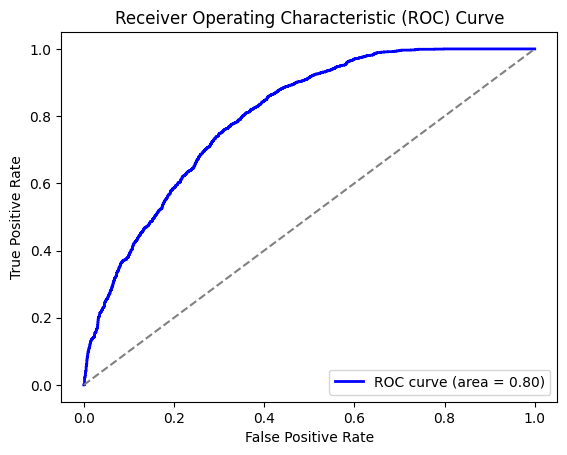

In [ ]:
# Evaluate predictor
trained_predictor.eval()
X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32)
y_preds = trained_predictor(X_test_tensor)
y_preds = y_preds.detach().cpu().numpy()
#y_test_numeric = y_test_numeric.cpu().numpy()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_numeric, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### 3c. Adversarial results for Ethnicity

In [ ]:
select_demog_var = 'ETHNICITY'

le = LabelEncoder()
sensitive_train = le.fit_transform(demogonly_train[select_demog_var])  # example for insurance
sensitive_test = le.transform(demogonly_test[select_demog_var])

req_cols = [v for v in xgb_model.feature_names_in_ if v not in demog_columns]

X_train_numeric = X_train[req_cols].astype(np.float32)
X_test_numeric = X_test[req_cols].astype(np.float32)
y_train_numeric = y_train.astype(np.float32)
y_test_numeric = y_test.astype(np.float32)

sensitive_train = sensitive_train.astype(np.int64)
sensitive_test = sensitive_test.astype(np.int64)

# Create training and validation loaders
# X_train, y_train, sensitive_train are pandas DataFrame/Series or numpy arrays
train_loader = get_adversarial_dataloader(X_train_numeric, y_train_numeric, sensitive_train, batch_size=64, shuffle=True)
test_loader = get_adversarial_dataloader(X_test_numeric, y_test_numeric, sensitive_test, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda")
hidden_dim = 64  # should match PredictorNet's hidden_dim
num_sensitive_classes = len(np.unique(sensitive_train))  # number of unique insurance groups
predictor = PredictorNet(input_dim=X_train_numeric.shape[1], hidden_dim=hidden_dim).to(device)
adversary = AdversaryNet(hidden_dim=hidden_dim, num_classes=num_sensitive_classes).to(device)
predictor_optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-3)
adversary_optimizer = torch.optim.Adam(adversary.parameters(), lr=1e-3)

predictor_loss_fn = nn.BCELoss()
#adversary_loss_fn = nn.BCELoss()
adversary_loss_fn = nn.NLLLoss()

trained_predictor, trained_adversary = train_adversarial_model(
    predictor, adversary,
    train_loader, test_loader,
    predictor_optimizer, adversary_optimizer,
    predictor_loss_fn, adversary_loss_fn,
    device=device,
    num_epochs=20,
    lambda_adv=1.0  # You can tune this for stronger/weaker debiasing
)

Epoch 1: Predictor AUC=0.732, Acc=0.658, TPR gap=0.249, Adversary Acc=0.701
Epoch 2: Predictor AUC=0.772, Acc=0.702, TPR gap=0.173, Adversary Acc=0.702
Epoch 3: Predictor AUC=0.784, Acc=0.716, TPR gap=0.221, Adversary Acc=0.702
Epoch 4: Predictor AUC=0.794, Acc=0.713, TPR gap=0.181, Adversary Acc=0.702
Epoch 5: Predictor AUC=0.795, Acc=0.720, TPR gap=0.217, Adversary Acc=0.702
Epoch 6: Predictor AUC=0.796, Acc=0.708, TPR gap=0.113, Adversary Acc=0.702
Epoch 7: Predictor AUC=0.798, Acc=0.674, TPR gap=0.002, Adversary Acc=0.702
Epoch 8: Predictor AUC=0.799, Acc=0.711, TPR gap=0.109, Adversary Acc=0.702
Epoch 9: Predictor AUC=0.798, Acc=0.722, TPR gap=0.169, Adversary Acc=0.702
Epoch 10: Predictor AUC=0.799, Acc=0.717, TPR gap=0.142, Adversary Acc=0.703
Epoch 11: Predictor AUC=0.801, Acc=0.722, TPR gap=0.158, Adversary Acc=0.703
Epoch 12: Predictor AUC=0.800, Acc=0.727, TPR gap=0.215, Adversary Acc=0.702
Epoch 13: Predictor AUC=0.803, Acc=0.724, TPR gap=0.206, Adversary Acc=0.703
Epoch 14

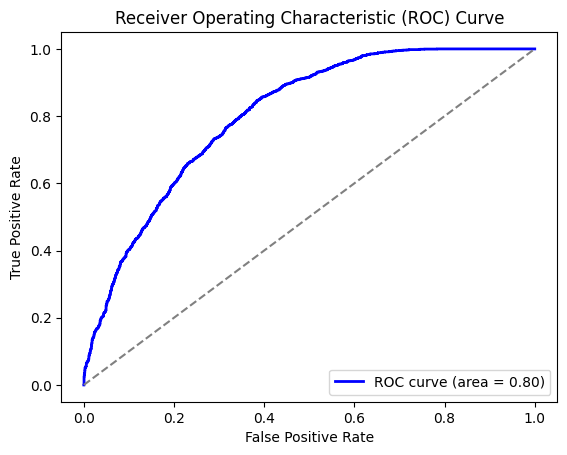

In [ ]:
# Evaluate predictor
trained_predictor.eval()
device = next(trained_predictor.parameters()).device
X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_preds = trained_predictor(X_test_tensor)
y_preds = y_preds.detach().cpu().numpy()
#y_test_numeric = y_test_numeric.cpu().numpy()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_numeric, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
